In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from importlib import reload
import os
from os.path import join
import subprocess
import sys
sys.path.append('../../') # lets us import ptype package from the subdir
#import ptype.
import time
from tqdm import tqdm


import soundings.utils as utils
import soundings.mr_analysis as mra
from soundings.mr_analysis import SoundingQuery

select 

- variable to plot
- subset of data:
    - 'case_study_day' : 
        - 'new_york_1-20221215', 'new_york_1-20221216', 'new_york_1-20221217', 
        - 'new_york_2-20220203', 'new_york_2-20220204', 
        - 'kentucky-20220223','kentucky-20220224'
    - init_hr:
        - rap,hrrr: 0 - 23
    - step:
        - np.timedelta(x, 'h') for x = 1, ..., 18

In [2]:
data_dir = "/glade/work/dkimpara/ptype-aggs"
model = 'hrrr'
ds = xr.open_dataset(join(data_dir,f"{model}_all.nc"), engine='netcdf4')
query = SoundingQuery(ds)

color_dict = {'NWP': '#1F77B4',
              'ML': '#FF7F0E'}

lstyledict = {'t_h': 'solid',
              'dpt_h': 'dashed',
              'wb_h': 'dotted',
              'num_obs': 'dashed',
              'fabv': 'solid'}



# plotting code

In [3]:
class minmaxscale():
    def __init__(self, values, range_min, range_max):
        self.mini = min(values)
        self.maxi = max(values)
        self.rangesize = (range_max - range_min)
        self.range_min = range_min
    def scale(self, value):
        return  self.rangesize * (value - self.mini) / (self.maxi - self.mini) + self.range_min

def plot_leadtimes(ax, query, times, predtype, color):
    scaler = minmaxscale(times, 0.1, 0.8)
    h = ds.heightAboveGround
    
    plotted_steps = []
    for t in tqdm(times, desc = f'Plotting all steps (if exists) for {predtype}'):
        step = np.timedelta64(t, 'h')
        alpha = scaler.scale(-1 * t + scaler.maxi + 1) #smaller step, darker color
        if stat == 'median':
            profile = query.quantile(0.5, predtype, var, {'step': [step]} | select_case)
            profile = profile[f'{var}_q'].sel(quantile=0.5).values.flatten()
        else:
            profile = query.query(predtype, var, stat, {'step': [step]} | select_case)
            profile = profile[f'{var}_{stat}'].values.flatten()
        
        ax.plot(profile, h, color=color, linestyle=lstyledict[var],
                alpha=alpha)
        if not (np.any(np.isnan(profile)) or np.all(profile == -59.95)):
            plotted_steps.append(t)
    return ax, plotted_steps

def plot_num_obs(t_ax, plotted_steps, query, predtype, color):
    num_obs = []
    for t in plotted_steps:
        step = np.timedelta64(t, 'h')
        obs = query.num_obs(predtype, {'step': [step]} | select_case).values[0]
        num_obs.append(obs)
    
    t_ax.plot(plotted_steps, num_obs, color=color, linestyle=lstyledict['num_obs'])
    
    #t_ax.relim()
    # update ax.viewLim using the new dataLim
    #t_ax.autoscale()
    return t_ax

def plot_frac_abv_0(fabv_ax, plotted_steps, query, predtype, color):
    fabv = []
    for t in plotted_steps:
        step = np.timedelta64(t, 'h')
        frac = query.query(predtype, var, 'fabv',
                          {'step': [step]} | select_case)[f'{var}_fabv'].values[0]
        fabv.append(frac)
    
    fabv_ax.plot(plotted_steps, fabv, color=color, linestyle=lstyledict['fabv'])
    
    #t_ax.relim()
    # update ax.viewLim using the new dataLim
    #t_ax.autoscale()
    return fabv_ax

def plot_by_step(steps = [1, 6, 12, 18]):

    bad = ['cfrzr', 'cicep']
    good = ['csnow', 'crain']
    allptypes = [bad,good]
    res_axs = []
    t_axs = []

    for pair in allptypes:
        fig, axs = utils.skewCompositeFigAx(figsize=(12,10), rows=2, cols=2)
        timeax = axs[1]
        axs = axs[0]
        
        for ax, t_ax, ptype in zip(axs, timeax, pair):
            ax, _ = plot_leadtimes(ax, query, steps, 'ML_' + ptype, color_dict['ML'])
            ax, plotted_steps = plot_leadtimes(ax, query, steps, ptype, color_dict['NWP'])
                        
                    
            line, = ax.plot([],[], color=color_dict['ML'])
            line.set_label(f'ML')
            line, = ax.plot([],[], color=color_dict['NWP'])
            line.set_label(f'{model}')

            ax.set_xlabel('Temperature (C)')
            ax.set_ylabel('HeightAboveGround (m)')
            ax.set_xlim(-10,20)
            ax.set_title(f'{ptype[1:]} {stat} {var}')
            ax.legend(title=f'Displayed steps:\n{plotted_steps}h\nDarker = smaller step')
            
            
            #plot num_obs
            t_ax = plot_num_obs(t_ax, plotted_steps, query, 'ML_' + ptype, color_dict['ML'])
            t_ax = plot_num_obs(t_ax, plotted_steps, query, ptype, color_dict['NWP'])
            t_ax.relim()
            # update ax.viewLim using the new dataLim
            t_ax.autoscale()
            t_ax.set_ylim(0)
            t_ax.set_xticks(plotted_steps)
            
            t_ax.set_title(f'{ptype[1:]} Number of Observations\nand Fraction Above 0')
            t_ax.set_xlabel('Step (h)')
            t_ax.set_ylabel('Number of Observations')

            fabv_ax = t_ax.twinx()  # instantiate a second axes that shares the same x-axis
            fabv_ax = plot_frac_abv_0(fabv_ax, plotted_steps, query, 'ML_' + ptype, color_dict['ML'])
            fabv_ax = plot_frac_abv_0(fabv_ax, plotted_steps, query, ptype, color_dict['NWP'])
            fabv_ax.set_ylabel('Fraction Above 0') 
            fabv_ax.set_ylim(0,1.1)
            
            line, = t_ax.plot([],[], color='0', linestyle=lstyledict['num_obs'])
            line.set_label(f'Num obs')
            line, = t_ax.plot([],[], color='0', linestyle=lstyledict['fabv'])
            line.set_label(f'fraction above 0')
            t_ax.legend()
            res_axs.append(ax)
            t_axs.append(t_ax)
        fig.suptitle(f'Data Subset: {select_case}', fontsize=10)
            
    return res_axs, t_axs

# plots

Plotting all steps (if exists) for crain: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


(-6.0, 10.0)

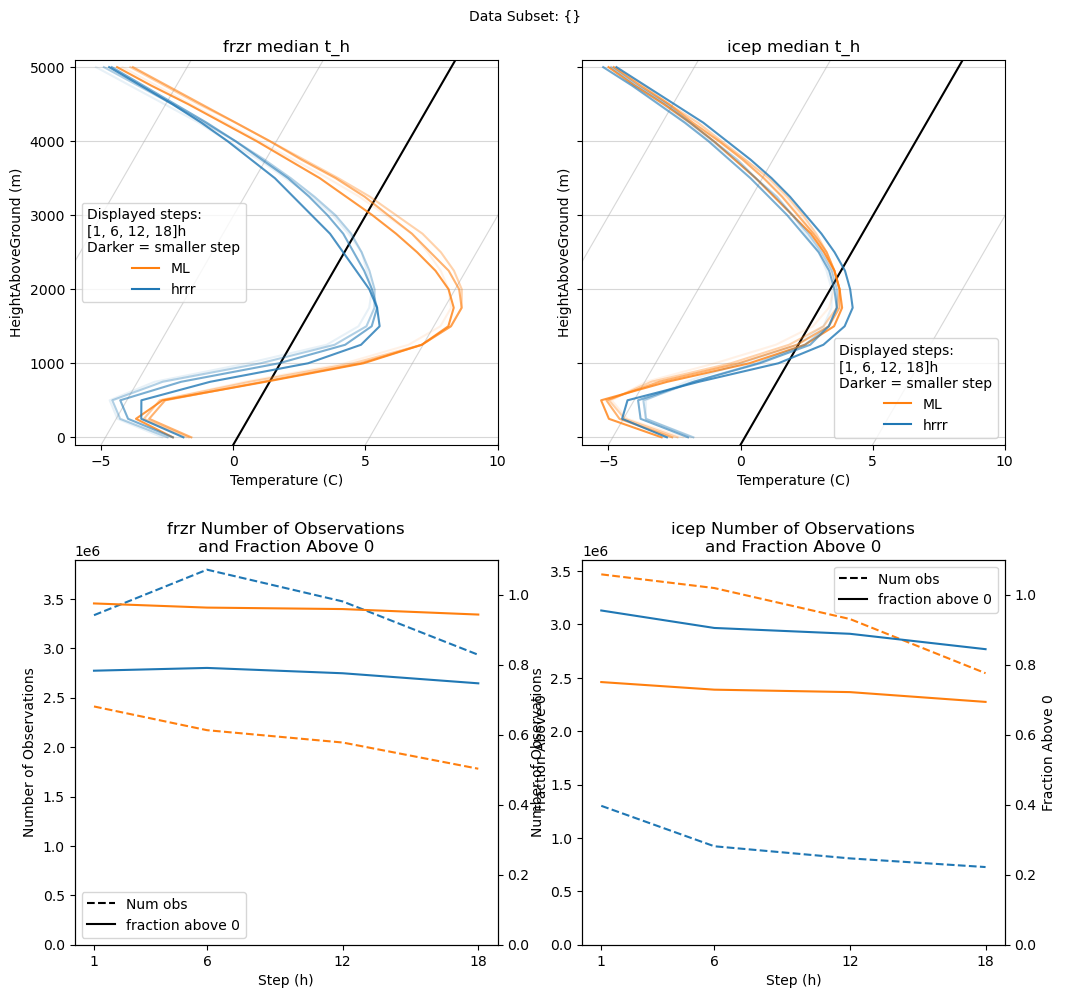

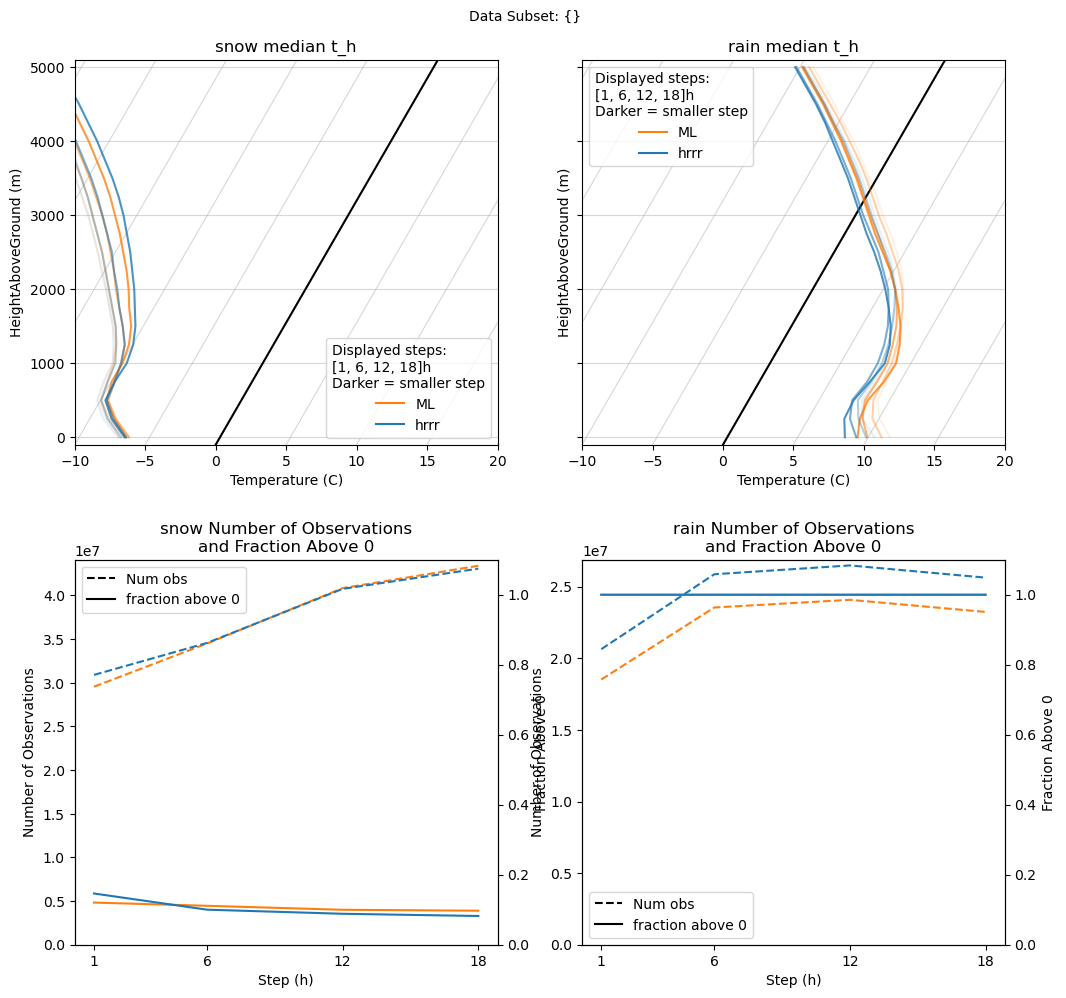

In [4]:
select_case = {
               #'case_study_day': 'kentucky-20220224',
               #'init_hr': [0,2],
              }
#which profile to plot
var = 't_h'
stat= 'median' #mean or median
reload(utils)
res_axs, t_axs = plot_by_step()
res_axs[0].set_xlim(-6,10)
res_axs[1].set_xlim(-6,10)
    

## plot the same figures and selecting by case_study_day, valid_time, init_hr, etc

Plotting all steps (if exists) for crain: 100%|██████████| 4/4 [00:10<00:00,  2.66s/it]


(-6.0, 12.0)

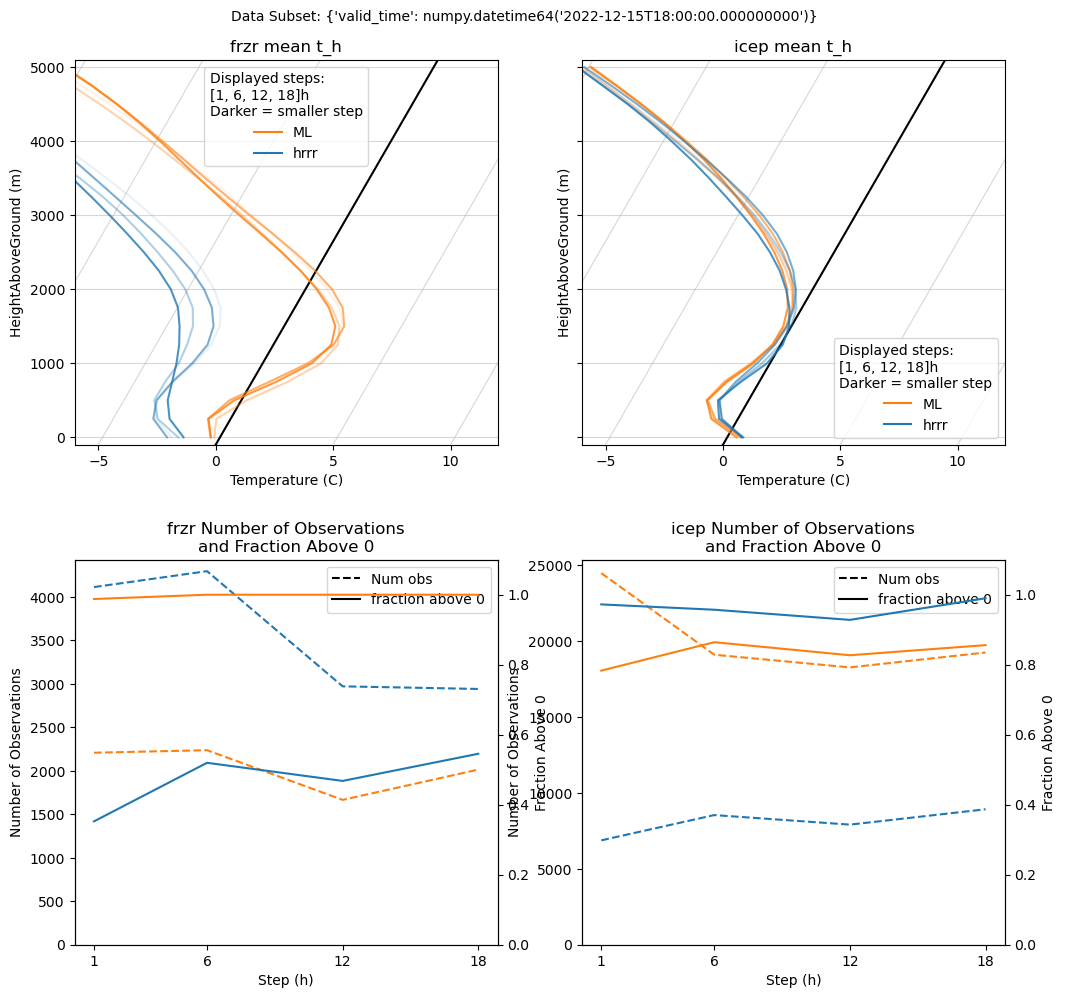

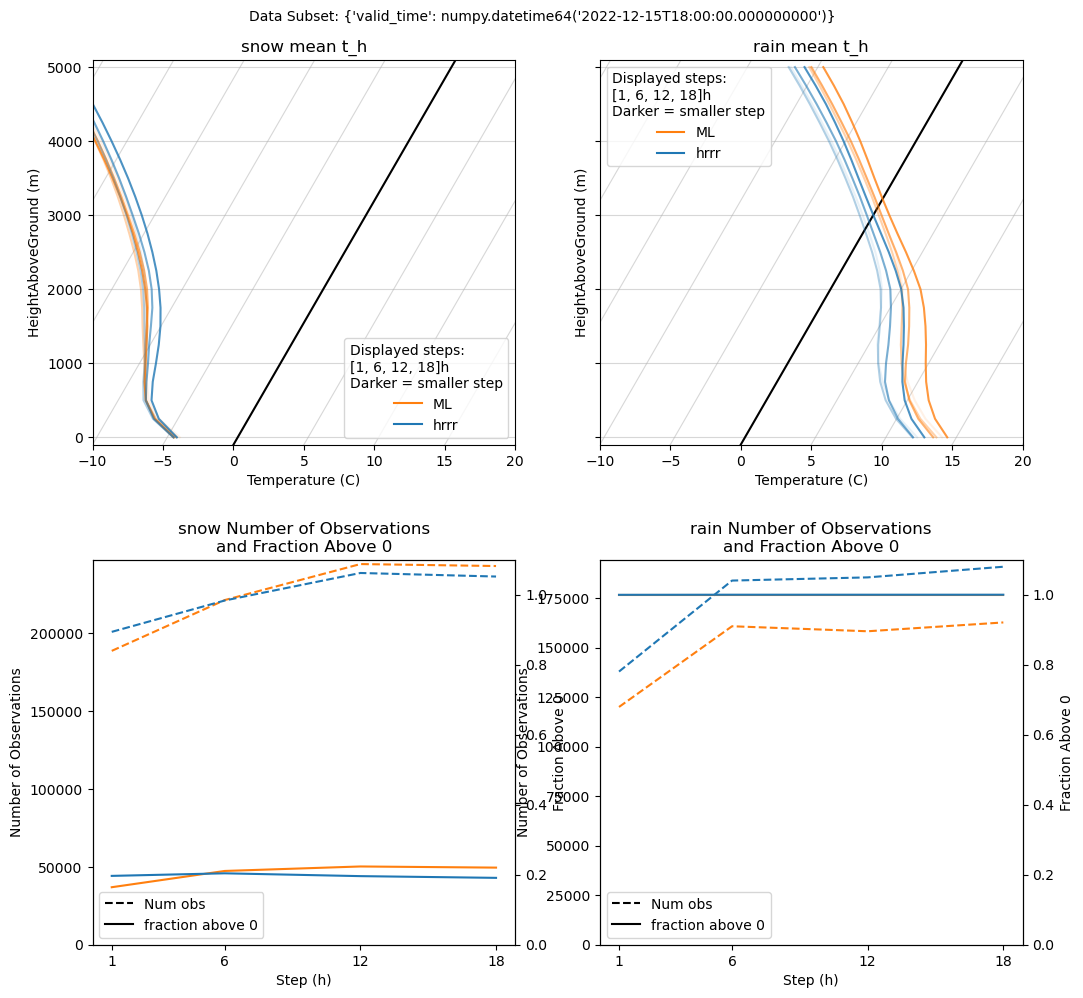

In [5]:
# code will take care of nans for you
# takes a little longer because masking by valid_time instead of selecting
select_case = {
               #'case_study_day': 'new_york_1-20221215',
               #'init_hr': [0,2],
               'valid_time': np.datetime64('2022-12-15T18:00:00.000000000')
              } 
#which profile to plot
var = 't_h'
stat= 'mean' #mean or median

res_axs, _ = plot_by_step()
res_axs[0].set_xlim(-6,12)
res_axs[1].set_xlim(-6,12)

In [6]:
res_axs

[<SkewXAxes: title={'center': 'frzr mean t_h'}, xlabel='Temperature (C)', ylabel='HeightAboveGround (m)'>,
 <SkewXAxes: title={'center': 'icep mean t_h'}, xlabel='Temperature (C)', ylabel='HeightAboveGround (m)'>,
 <SkewXAxes: title={'center': 'snow mean t_h'}, xlabel='Temperature (C)', ylabel='HeightAboveGround (m)'>,
 <SkewXAxes: title={'center': 'rain mean t_h'}, xlabel='Temperature (C)', ylabel='HeightAboveGround (m)'>]